# Text Mining Project Work (Group 1)

**Text Classification and Sentiment Analysis**

_Prof. Gianluca Moro, Dott. Ing. Nicola Piscaglia – DISI, University of Bologna_

**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Instructions
- The provided exercises must be executed by the students of Group 1
- At the end, the file must contain all the required results (as code cell outputs) along with all the commands necessary to reproduce them; 
- The function of every command or group of related commands
must be documented clearly and concisely. 
- The submission deadline is the 1st July 2022.
- When finished, one team member will send the notebook file (having .ipynb extension) via mail (using your BBS email account) to the teacher (nicola.piscaglia@bbs.unibo.it) indicating “[BBS Teamwork] Your last names” as subject, also keeping an own copy of the file for safety.
- You are allowed to consult the teaching material and to search the Web for quick reference. 
- If still in doubt about anything, ask the teacher
- It is severely NOT allowed to communicate with other teams. Ask the teacher for any clarification about the exercises.
- Each correctly developed point counts 2/30.

## Setup

The following cell contains some necessary imports

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 30.7 MB/s 
     |████████████████████████████████| 596 kB 41.8 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 59.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import gzip
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from urllib.request import urlretrieve

Run the following to download the necessary files

In [3]:
def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

In [4]:
download("Magazine_Subscriptions.json.gz", "https://www.dropbox.com/s/g6om8q8c8pvirw8/Magazine_Subscriptions.json.gz?dl=1")

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Exercises

1) We provide in the `Magazine_Subscriptions.json.gz` file a dataset composed by several reviews posted on Amazon.com about Magazine Subscriptions. 
Each review is labeled with a score between 1 and 5 stars (represented by the ```overall``` feature).

The text of each review is represented by the ```reviewText``` feature which is going to be our input data along with the ```overall``` one.

Load the dataset putting it in a new Pandas dataframe.

In [6]:
def parse(path):
  gzip_file = gzip.open(path, 'rb')
  for file_line in gzip_file:
    yield json.loads(file_line)

def getDF(path):
  index = 0
  df = {}
  for entry in parse(path):
    df[index] = entry
    index += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF('Magazine_Subscriptions.json.gz')

2) Print the dataset rows number and visualize the first 5 rows.

In [88]:
data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,1.0,22,False,"08 14, 2007",A2P7ETBL7020DF,B000O1PKOG,Gary Smith,This magazine has a catchy title and very nice...,Just plain lame.,1187049600,{'Format:': ' Print Magazine'},NaN
1,1.0,3,False,"01 9, 2014",AONC3Q7956CQ6,B00005N7T5,J-Lick,Before it was easy to go directly to the New Y...,Very Dissapointed in the on line format,1389225600,{'Format:': ' Kindle Edition'},NaN
2,1.0,11,False,"09 7, 2009",A9004RLMUCQCJ,B00077B7M6,PT,I don't really understand why this product is ...,Extremely Expensive,1252281600,{'Format:': ' Kindle Edition'},NaN
3,1.0,NaN,False,"10 9, 2015",A1DEYML4ZKN1WV,B00HG1BP0U,Angie,Looked nicer in the picture,One Star,1444348800,{'Format:': ' Print Magazine'},NaN
4,1.0,NaN,True,"07 23, 2014",A3ULPJ814I5LP6,B000IOEK7M,John,Never received.,One Star,1406073600,NaN,NaN


3) Undersample the data by `overall` feature in order to obtain a class-balanced dataset.



In [8]:
rus = RandomUnderSampler(random_state=42)
data, _ = rus.fit_resample(data, data["overall"])

4) Cast the `reviewText` column to unicode string



In [9]:
data['reviewText'] = data['reviewText'].astype('unicode')

**5)** Select from data only the features named ```reviewText``` and ```overall``` putting them in a dataframe





In [10]:
data2 = data[['reviewText', 'overall']].copy()

**6)** Verify the distribution of the number of stars

In [11]:
data2["overall"].value_counts()

1.0    5223
2.0    5223
3.0    5223
4.0    5223
5.0    5223
Name: overall, dtype: int64

**7)** Remove from the dataframe the reviews rated with 3 stars.

In [12]:
data2 = data2.drop(data2[data2.overall==3.0].index)

**8)** Add a `label` column to the DataFrame whose value is `"pos"` for reviews with 4 stars, `"very_pos"` for 5-rated reviews, `"neg"` for reviews with 2 stars and `"very_neg"` for 1-rated reviews.

In [13]:
def newlabel(value):
  if value == 4.0:
    return "pos"
  elif value == 5.0:
    return "very_pos"
  elif value == 2:
    return "neg"
  elif value == 1:
    return "very_neg"

In [14]:
data2["label"] = data["overall"].apply(newlabel)

**9)** Split the dataset randomly into a training set with 70% of data and a test set with the remaining 30%, stratifying the split by the `label` variable

In [15]:
y = data2["label"]
X = data2["reviewText"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("training set shape: " + str(X_train.shape))
print("Test set shape: " + str(X_test.shape))

training set shape: (14624,)
Test set shape: (6268,)


**10)** Create a tf.idf vector space model from training reviews excluding words appearing in less than 3 documents and using bigrams in addition to single words. Then, extract the document-term matrix for them.

In [16]:
vect = TfidfVectorizer(min_df=3, ngram_range=(1,2))
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

**11)** Train a logistic regression classifier on the training reviews, using the representation created above

In [17]:
%%time
model = LogisticRegression(max_iter=500)
model.fit(train_dtm, y_train);

CPU times: user 13 s, sys: 13.8 s, total: 26.8 s
Wall time: 18.7 s


**12)** Verify the accuracy of the classifier on the test set

In [18]:
model.score(test_dtm, y_test)

0.6078493937460114

**13)** Get the model predictions and print the confusion matrix

In [19]:
y_pred = model.predict(test_dtm)

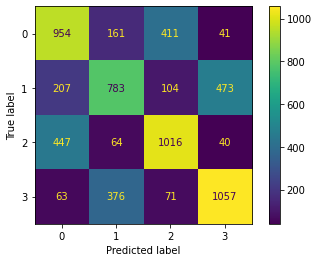

In [20]:
calculated_confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(calculated_confusion_matrix)
confusion_matrix_display.plot();

14) Train a Deep Learning model of your choice (excluding transformer-based models like BERT) using the document-term representation built in point 10 and evaluate it on test data. Try to maximize the model accuracy. The usage of recurrent layers is up to you.

In [21]:
'pip install -U gensim'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 69.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [22]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
#import gensime
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [23]:
num_terms = len(vect.get_feature_names_out())

In [24]:
#function to create matrix table for y_train/y_test target
def make_target(labels):
    return pd.DataFrame({
        "pos": labels == "pos",
        "neg": labels == "neg",
        "very_pos": labels == "very_pos",
        "very_neg": labels == "very_neg"
    }).astype(int)

In [25]:
train_target = make_target(y_train)
test_target = make_target(y_test)

In [26]:
#We decided to use Multi-Layer Perceptron
from keras.models import Sequential
model = Sequential()

In [27]:
from keras.layers import Dense
model.add(Dense(4, activation="softmax", input_dim=num_terms))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [28]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
# Garbage Collector library
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [30]:
fit_history = model.fit(train_dtm, train_target, batch_size=200, epochs=5, callbacks=[GarbageCollectorCallback()])


Epoch 1/5
14624/14624 [==============================] - 4s 269us/step - loss: 1.3637 - accuracy: 0.4547
Epoch 2/5
14624/14624 [==============================] - 4s 277us/step - loss: 1.3021 - accuracy: 0.6488
Epoch 3/5
14624/14624 [==============================] - 5s 319us/step - loss: 1.2475 - accuracy: 0.7092
Epoch 4/5
14624/14624 [==============================] - 5s 312us/step - loss: 1.1978 - accuracy: 0.7349
Epoch 5/5
14624/14624 [==============================] - 4s 301us/step - loss: 1.1523 - accuracy: 0.7474


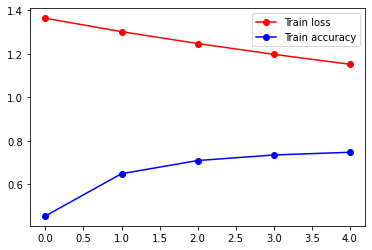

In [31]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Train loss", "Train accuracy"]);

In [32]:
print("test loss, test acc: ", model.evaluate(test_dtm, test_target))

6268/6268 [==============================] - 2s 300us/step
test loss, test acc:  [1.2016876085442043, 0.578334391117096]


In [33]:
ypred3= model.predict_classes(test_dtm.toarray())

In [34]:
#Create dictionary to converte array value for McNemar test
dit={0:'pos', 1:'neg', 2:'very_pos', 3:'very_neg'}

In [35]:
#convertion
pre = [dit[letter] for letter in ypred3]
pred10= np.asarray(pre)

15) Get the predictions of this latter model and compare them with the Logistic Regression model ones trained in point 11 using the McNemar test and setting a confidence level = 95% (i.e. p-value must be > 0.05 for models to be significantly similar). 

Hint: you will need to adapt the type of the two model predictions to integer arrays in order to be compared.


To obtain the p-value, you can use the provided `mcnemar_pval` function providing the arrays with the labels predicted by the two models and the true ones.

```
mcnemar_pval(model1_predictions, model2_predictions, y_test)
```


In [36]:
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_pval(p1, p2, y_test):
    model1_errors = p1 != y_test
    model2_errors = p2 != y_test

    print(model1_errors, model2_errors)

    # define contingency table
    mc_table = pd.crosstab(model1_errors, model2_errors)
    
    print(mc_table)
    
    # calculate mcnemar test
    mc_result = mcnemar(mc_table)
    print("p_value: ", mc_result.pvalue)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
#y_pre is our prediction from regression model
#pred10 in  our  prediction from NN
mcnemar_pval(y_pred, pred10, y_test)

25723    False
23454    False
8047      True
319      False
2987     False
         ...  
1432     False
7780      True
22732    False
20863     True
6169      True
Name: label, Length: 6268, dtype: bool 25723     True
23454    False
8047      True
319       True
2987     False
         ...  
1432     False
7780      True
22732    False
20863     True
6169      True
Name: label, Length: 6268, dtype: bool
label  False  True
label             
False   3253   557
True     372  2086
p_value:  1.3927540462349506e-09


16) Extra: train/fine-tune a transformer-based model (e.g. BERT) on training reviews and evaluate it on the test reviews.

In [39]:
from sklearn import preprocessing
import collections

# String labels conversion to integers
le = preprocessing.LabelEncoder()

train_labels1 = le.fit_transform(y_train)
collections.Counter(train_labels1)

Counter({0: 3656, 1: 3656, 2: 3656, 3: 3656})

In [40]:
# String labels conversion to integers
test_labels = le.fit_transform(y_test)
collections.Counter(test_labels)

Counter({0: 1567, 1: 1567, 2: 1567, 3: 1567})

In [41]:
train_texts, val_texts, train_labels, val_labels = train_test_split(X_train.tolist(), train_labels1, test_size=.1)

In [42]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [43]:
train_texts2 = np.array(train_texts)
val_texts2 = np.array(val_texts)
X_test2 = np.array(X_test)

In [44]:
train_texts2 = list(train_texts2.astype('str'))
val_texts2 = list(val_texts2.astype('str'))
X_test2 = list(X_test2.astype('str'))

In [45]:
train_encodings = tokenizer(train_texts2, truncation=True, padding=True)
val_encodings = tokenizer(val_texts2, truncation=True, padding=True)
test_encodings = tokenizer(X_test2, truncation=True, padding=True)

In [46]:
## PYTORCH CODE
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [58]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [59]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights fi

In [60]:
## PYTORCH CODE
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, BertForSequenceClassification

torch.set_grad_enabled(True) # Enable gradient calculation to perform the training

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    do_eval=True,                    # enable/disable the evaluation on the validation set during the training
    evaluation_strategy='steps',     # whether to validate the model each N steps or at the end of each epoch
    eval_steps=30                   # If evaluation strategy is set to 'steps' then the model will be evaluted each 'eval_steps' on the validation set during the training
)
# If you want to customize more the training arguments...
# https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13161
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 823


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
30,1.376700,1.381466,0.273411,0.139858,0.281994,0.273411
60,1.370900,1.365612,0.380041,0.308861,0.349475,0.380041
90,1.333500,1.301552,0.476418,0.460406,0.513430,0.476418
120,1.139200,1.110733,0.514696,0.497391,0.521449,0.514696
150,1.002500,0.991827,0.510595,0.437219,0.485421,0.510595
180,0.993000,0.981585,0.497608,0.410125,0.459899,0.497608
210,1.070900,0.969813,0.563226,0.550126,0.594835,0.563226
240,0.926200,0.919449,0.570062,0.521340,0.590069,0.570062
270,0.823500,0.927472,0.596719,0.594664,0.603195,0.596719
300,1.032700,0.940287,0.561859,0.546092,0.613332,0.561859


***** Running Evaluation *****
  Num examples = 1463
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 1463
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 1463
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1463
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1463
  Batch size = 64
***** Running Evaluatio

TrainOutput(global_step=823, training_loss=0.9555540953922388, metrics={'train_runtime': 1212.275, 'train_samples_per_second': 10.856, 'train_steps_per_second': 0.679, 'total_flos': 1743465615962112.0, 'train_loss': 0.9555540953922388, 'epoch': 1.0})

In [ ]:
#Bart report

#TrainOutput(global_step=823, training_loss=0.9555540953922388, 
#metrics={'train_runtime': 1212.275, 'train_samples_per_second': 10.856,
# 'train_steps_per_second': 0.679, 'total_flos': 1743465615962112.0, 'train_loss': 0.9555540953922388, 'epoch': 1.0})

In [61]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 6268
  Batch size = 64


{'epoch': 1.0,
 'eval_accuracy': 0.6314613911933631,
 'eval_f1': 0.6302521434278653,
 'eval_loss': 0.8124783635139465,
 'eval_precision': 0.6298309508361757,
 'eval_recall': 0.6314613911933631,
 'eval_runtime': 96.4826,
 'eval_samples_per_second': 64.965,
 'eval_steps_per_second': 1.016}

In [105]:
sentence_to_be_classified = "A great read every issue."  # You can type an arbitrary sentence to be summarized
sentence_to_be_classified2 = "Looked nicer in the picture"

In [90]:
def prova(we):
  on_demand_test_encodings = tokenizer([we], truncation=True, padding=True)
  on_demand_test_dataset = IMDbDataset(on_demand_test_encodings, le.transform(['neg']))

  result = trainer.predict(on_demand_test_dataset)
  print("Logits: " + str(result.predictions))
  return result.predictions

In [83]:
pos= prova(sentence_to_be_classified)

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Logits: [[-2.402423   1.653131  -1.8981713  2.9689398]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
neg= prova(sentence_to_be_classified2)

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Logits: [[-0.45173267  1.5541959  -1.3950561   0.2807142 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
import torch
#probabilities function
def prob(we):
  # Convert logits to probabilities using softmax
  p = torch.nn.functional.softmax(torch.from_numpy(we), dim=1)
  print("Probabilities: " + str(p))

  # Get the predicted classes for each output
  top_p, top_class = p.topk(1, dim = 1)
  print("Top class: " + str(top_class[0][0].item()))

  print() 

  if (top_class.numpy()[0] == 1):
    print('The sentence polarity is positive')
  else:
    print('The sentence polarity is negative.')

In [108]:
prob(pos)

Probabilities: tensor([[0.0036, 0.2095, 0.0060, 0.7809]])
Top class: 3

The sentence polarity is negative.


In [109]:
prob(neg)

Probabilities: tensor([[0.0917, 0.6818, 0.0357, 0.1908]])
Top class: 1

The sentence polarity is positive
